# Finding data offset
We want to find the centroid offset for all data frames of HD-37093 taken in the commissioning run. First let's see this all works for a single frame (the first)

In [2]:
from astropy.io import fits
import pandas as pd
import webbpsf
import dLux as dl
from dLux.utils import deg_to_rad as d2r
from dLux.utils import rad_to_arcsec as r2a
from dLux.utils import arcsec_to_rad as a2r
import jax.numpy as np
from optics import NIRISSOptics
from utils import plot_and_compare
from scipy.optimize import minimize
from detector_layers import DistortionFromSiaf
import matplotlib.pyplot as plt

plt.rcParams['image.origin'] = 'lower'

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-059 CANNOT BE CHECKED AGAINST ONLINE VERSION


dLux: Jax is running in 32-bit, to enable 64-bit visit: https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision


String manipulation for reading in the data files.

In [3]:
data_path = 'data/calints/'
info_path = 'data/comm_1093_exposure_info_epoch2.txt'

def uncal_to_calints(filename):
    return filename[:-10] + 'calints.fits'

Reading in the data

In [4]:
# DATA
# reading table to pandas dataframe
df = pd.read_table(info_path, sep='\s+', header=0, skiprows=[1])

# selecting HD-37093 target
HD37093 = df[df['TARGPROP'] == 'HD-37093']

file_idx = 0  # selecting first file
HDUList = fits.open(data_path + uncal_to_calints(list(HD37093['DISKNAME'])[file_idx]))
"""
`HDUList.info()` returns:
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     319   ()
  1  SCI           1 ImageHDU        74   (64, 64, 1)   float32
  2  ERR           1 ImageHDU        11   (64, 64, 1)   float32
  3  DQ            1 ImageHDU        12   (64, 64, 1)   int32 (rescales to uint32)
  4  INT_TIMES     1 BinTableHDU     24   0R x 7C       [J, D, D, D, D, D, D]
  5  VAR_POISSON   1 ImageHDU        10   (64, 64, 1)   float32
  6  VAR_RNOISE    1 ImageHDU        10   (64, 64, 1)   float32
  7  VAR_FLAT      1 ImageHDU        10   (64, 64, 1)   float32
  8  ASDF          1 BinTableHDU     11   1R x 1C       [23361B]
"""

filt = list(HD37093['FILTER'])[file_idx]

sci_frame = np.array(HDUList['SCI'].data[0])
sci_frame_norm = sci_frame/sci_frame.sum()

Building the model

In [13]:
# MODEL
webbpsfobj = webbpsf.NIRISS()
webbpsfobj.calc_psf()  # calculating fits files
NIS_CEN_aperture = webbpsfobj.siaf.apertures['NIS_CEN']

osys = NIRISSOptics()
det = dl.LayeredDetector([
    dl.detector_layers.RotateDetector(-d2r(getattr(NIS_CEN_aperture, "V3IdlYAngle")), order=3),  # Rotates PSF
    DistortionFromSiaf(aperture=NIS_CEN_aperture),  # Wavefront sphere to wavefront plane
    dl.IntegerDownsample(kernel_size=4),  # Downsample to detector pixel scale
    # ApplyBFE(1e-6),  # Apply BFE
])

ValueError: Must specify either radial_orders or noll_indices

In [ ]:
a2r(webbpsfobj.pixelscale)

Defining the model and loss functions

In [8]:
def model(xoffset, yoffset):
    src = dl.PointSource(position=a2r(np.array([xoffset, yoffset])), **dict(np.load(f'filter_configs/{filt}.npz')))
    instrument = dl.Instrument(optics=osys, sources=src, detector=det)
    psf = instrument.model()
    psf = psf[6:-6, 6:-6]
    return psf/psf.sum()


def loss_fn(params):
    xoffset, yoffset = params
    generated_pattern = model(xoffset, yoffset)
    diff = sci_frame_norm - generated_pattern
    mse = np.mean(diff**2)
    return mse

Running gradient descent (note decreased tolerance)

In [9]:
initial_guess = np.array([0., 0.])  # Initial guess for xoffset and yoffset
result = minimize(loss_fn, initial_guess, bounds=[(-1e-6, 1e-6), (-1e-6, 1e-6)], method='L-BFGS-B', tol=1e-9)

NameError: name 'osys' is not defined

Plotting the result

In [ ]:
plot_and_compare(sci_frame_norm, model(*result.x), colorbars=True, titles=['JWST Data', r'$\partial$Lux Model'])
print('Offsets: ', *result.x)
print('MSE: ', result.fun)

Okay, now let's do this for all the frames. We will ignore all frames that are not in the SUBTAAMI subarray, because the SUB80 array has a different image size.

In [15]:
offset_list = {}
for idx in range(HD37093.shape[0]):

    # checking subarray
    if list(HD37093['SUBARRAY'])[idx] != 'SUBTAAMI':
        continue

    # loading filter and science frame
    filename = data_path + uncal_to_calints(list(HD37093['DISKNAME'])[idx])
    HDUList = fits.open(filename)
    filt = list(HD37093['FILTER'])[idx]
    sci_frame = np.array(HDUList['SCI'].data[0])
    sci_frame_norm = sci_frame/sci_frame.sum()

    max_loc = np.where(sci_frame_norm == sci_frame_norm.max())  # get indices
    max_loc = ((np.array(max_loc) - sci_frame_norm.shape[0]/2 + 0.5) * webbpsfobj.pixelscale).T[0]  # convert to arcseconds
    max_loc = np.array([max_loc[1], -max_loc[0]])  # flip y axis ?? idk

    bound = np.array([[max_loc[0] - 0.01, max_loc[0] + 0.01], [max_loc[1] - 0.01, max_loc[1] + 0.01]])
    result = minimize(loss_fn, x0=max_loc, bounds=bound, method='Nelder-Mead', tol=1e-9)  # running descent

    offset_list[filename] = result.x  # saving offset

    plot_and_compare(sci_frame_norm, model(*result.x), colorbars=True, titles=['JWST Data', r'$\partial$Lux Model'])

The residuals look more or less like the gradient descent worked. Let's save the offsets.

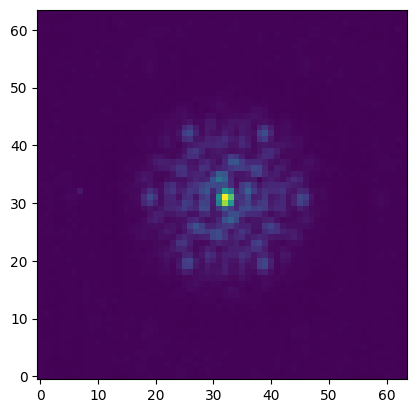

In [5]:
plt.imshow(sci_frame_norm)

In [ ]:
np.savez('data/HD-37093_offsets.npz', **offset_list)